In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gender-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F446365%2F844929%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T083903Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4db8723ddcf03d491172f0364a474c1c59c4f57f435e3c784a6a118056dad954f35820dc80db18440ec467445f8bf5371bbf74ae1aa0aaa2484ff48d9ac9b774c33d3e117d2a4c575a787dfdde19031dccd886566f3b6febb239277ee0c847a043731485735368a240c1631b98f459982f8526397c8fe5a300a8509fadfc5591b972fa1e2a739d9451069db6878a95784d1510f302efbe11fb6c38776835a68db1cf57b0b8b17a03ccdc7fd5026a73c56237adb2422375220b6591c53a07249eb76b19f19aa89707dd9020dde81c61534488d3f83f05c920b685c1851f573ade6a53e05e8a6c3286420c6df4f56ead9c608e6b4fae0d17b110209808dc7d1849'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 282512091 bytes downloaded
Downloaded and uncompressed: gender-classification-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_ds="/kaggle/input/gender-classification-dataset/Training"
test_ds="/kaggle/input/gender-classification-dataset/Validation"

# Data preprocessing
****

In [4]:
root_path = "/kaggle/input/gender-classification-dataset/Training/"
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)
class_dis = [len(os.listdir(root_path + name)) for name in class_names]
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")
print(f"female : {class_dis[0]} \nmale : {class_dis[1]}")

Total Number of Classes : 2 
Class Names : ['female', 'male']
female : 23243 
male : 23766


In [5]:
os.listdir('/kaggle/input/gender-classification-dataset/Training')

['female', 'male']

In [6]:
import plotly.express as px

In [7]:
fig = px.pie(names=class_names, values=class_dis,
             title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [8]:
valid_path = "/kaggle/input/gender-classification-dataset/Validation/"
valid_dis = [len(os.listdir(valid_path + name)) for name in class_names]
fig = px.pie(names=class_names, values=valid_dis,
             title="test Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255)#initialize train generator

test_datagen = ImageDataGenerator(rescale = 1.0/255.) #initialize test generator

In [10]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)

test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(train_ds,target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_ds,target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')


Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [11]:
train_generator[0][0].shape

(32, 224, 224, 3)

In [12]:
img= train_generator[0]
print(img)

(array([[[[140.7581   ,  99.758095 ,  68.51619  ],
         [140.       ,  99.       ,  67.       ],
         [143.1627   , 102.68982  ,  69.10847  ],
         ...,
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ]],

        [[140.75584  ,  99.75584  ,  68.51167  ],
         [140.       ,  99.       ,  67.       ],
         [143.16948  , 102.697716 ,  69.11298  ],
         ...,
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ]],

        [[140.75359  ,  99.75358  ,  68.50716  ],
         [140.       ,  99.       ,  67.       ],
         [143.17625  , 102.70562  ,  69.1175   ],
         ...,
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ],
         [ 65.       ,  54.       ,  48.       ]],

        ...,

        [[200.21074  , 139.97194  ,  

In [13]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [14]:
img = train_generator[0]
print(img[0].shape) # shape of the input batch
print(img[1].shape) # shape of the target labels

(32, 224, 224, 3)
(32, 2)


In [15]:
print(len(train_generator))
print(len(test_ds))

1470
54


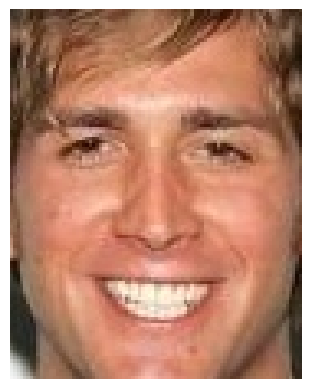

In [16]:
import matplotlib.pyplot as plt
from skimage import io

# Load image
img_url = "/kaggle/input/gender-classification-dataset/Training/male/090553.jpg.jpg"
img = io.imread(img_url)

# Display image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from keras.layers import MaxPool2D

# Build VVG_19 Model

In [17]:
# VGG 19 Model
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu', input_shape= input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(2, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.003),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [18]:
model = VGG19((224, 224, 3))

In [19]:
# Print the model summary

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                        

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [21]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [23]:
history =model.fit(train_generator, validation_data=test_generator, epochs=2)

Epoch 1/2
1470/1470 [==============================] - 896s 610ms/step - loss: 0.1346 - accuracy: 0.9526 - val_loss: 0.1023 - val_accuracy: 0.9615
Epoch 2/2
1470/1470 [==============================] - 892s 607ms/step - loss: 0.1238 - accuracy: 0.9566 - val_loss: 0.0923 - val_accuracy: 0.9661


In [24]:
n_categories = len(os.listdir('/kaggle/input/gender-classification-dataset/Validation'))# number of categories print(n_categories)

In [25]:
n_categories

2

In [26]:
results =pd.DataFrame(history.history)
results.head()

,loss,accuracy,val_loss,val_accuracy
0,0.134604,0.952562,0.102325,0.961456
1,0.123844,0.956583,0.092268,0.966092


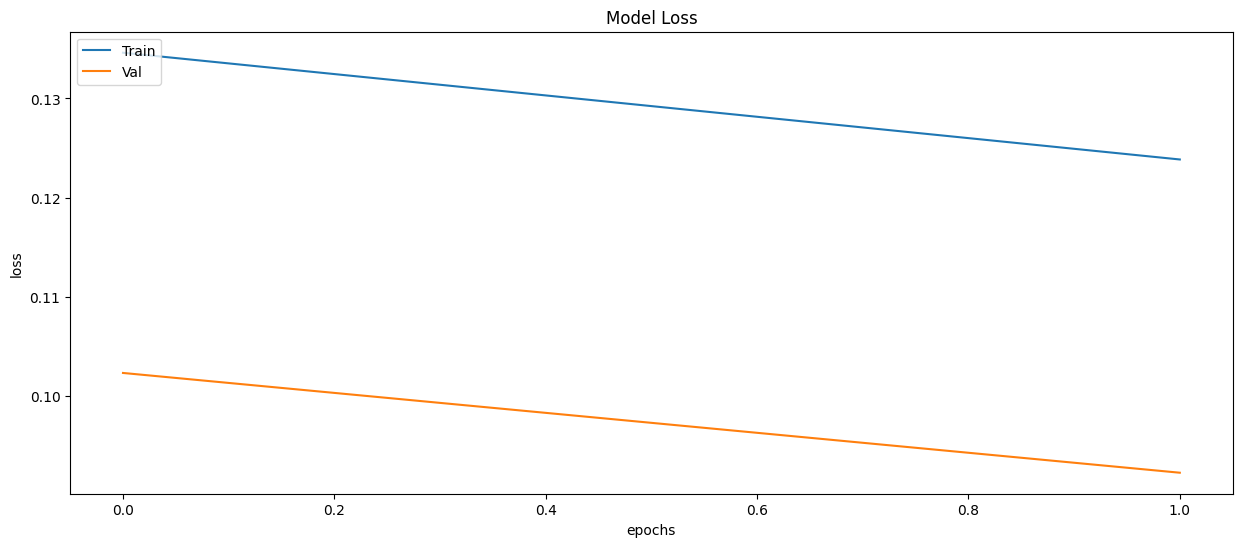

In [27]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

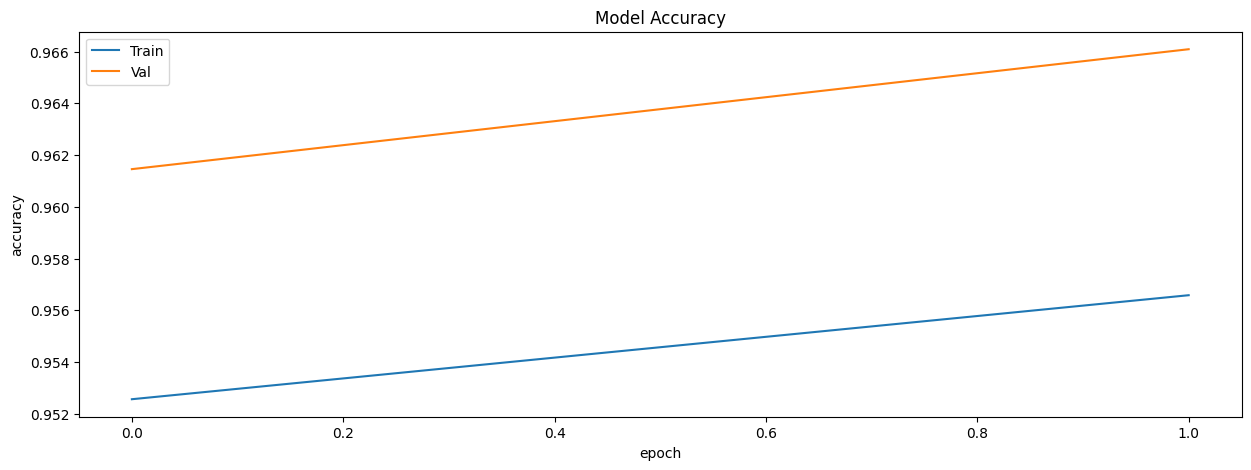

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [29]:
y_test_1 = test_generator.classes
y_pred_1 =model.predict(test_generator)
y_pred_1 = np.argmax(y_pred_1,axis=1)

365/365 [==============================] - 55s 150ms/step


In [30]:
results =model.evaluate(test_generator)

365/365 [==============================] - 55s 151ms/step - loss: 0.0923 - accuracy: 0.9661


In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5841
           1       0.96      0.98      0.97      5808

    accuracy                           0.97     11649
   macro avg       0.97      0.97      0.97     11649
weighted avg       0.97      0.97      0.97     11649

